In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
from scipy.signal import convolve2d
from scipy.signal import convolve
import copy
import json
import time as tm

In [20]:
"""
Changeable parameters
"""
filepath = 'data/cosmo_test_170125_'

n_strains = 2
n_nutrients = 2

#The dependencies of strain the strains on each nutrient. Within each strain and nutrient, COLUMN 1 is UPTAKE, 
#COLUMN 2 is RELEASE. 1 means they do that function, 0 means they do not
dependencies = np.zeros((n_strains,n_nutrients,2))


#This initialization is for classic CoSMO type crossfeeding.
dependencies[0,0,0] = 1 #strain 1, uptake nutrient 1
dependencies[0,1,1] = 1 #strain 1, release nutrient 2

dependencies[1,1,0] = 1 #strain 2, uptake nutrient 2
dependencies[1,0,1] = 1 #strain 2, release nutrient 1

#include this for cheater strain 3
#dependencies[2,1,0] = 1 #strain 3, uptake nutrient 2

#include this for cheater strain 3
#dependencies[2,2,0] = 1 #strain 2, uptake nutrient 2


"""
circle for n=3

dependencies[0,0,0] = 1 #strain 1, uptake nutrient 1
dependencies[0,1,1] = 1 #strain 1, release nutrient 2

dependencies[1,1,0] = 1 #strain 2, uptake nutrient 2
dependencies[1,2,1] = 1 #strain 2, release nutrient 3

dependencies[2,2,0] = 1 #strain 3, uptake nutrient 3
dependencies[2,0,1] = 1 #strain 2, release nutrient 1
"""


'\ncircle for n=3\n\ndependencies[0,0,0] = 1 #strain 1, uptake nutrient 1\ndependencies[0,1,1] = 1 #strain 1, release nutrient 2\n\ndependencies[1,1,0] = 1 #strain 2, uptake nutrient 2\ndependencies[1,2,1] = 1 #strain 2, release nutrient 3\n\ndependencies[2,2,0] = 1 #strain 3, uptake nutrient 3\ndependencies[2,0,1] = 1 #strain 2, release nutrient 1\n'

In [53]:
"""
general variables for diffusion
"""

side_len = 750 #microns
box_height = 300 #microns
cell_size = 5 #microns
cell_to_diff_ratio = 10
density = 10 #mm^-2

t_final = 0.5 #hrs
dt_cell = 0.1 #hrs
dt_diff = 1 #second
dt_cell_to_diff_ratio = 360

nsteps = int(t_final/dt_cell)
time = np.arange(nsteps)/dt_diff + dt_diff

D = 20 #um^2/s
DS = D/np.square(cell_size*cell_to_diff_ratio) #cell_side^2/s
print(DS)

0.008


In [54]:
"""
calculated quantities
"""
#the box to keep cells in
cell_sides = int(side_len/cell_size)
cell_height = int(box_height/cell_size)
X = np.zeros((cell_sides,cell_sides,cell_height))

#the boxes for each nutrient
diff_sides = int(cell_sides/cell_to_diff_ratio)
diff_height = int(cell_height/cell_to_diff_ratio)

#The blank matrix into which nutrients will go
S = np.zeros((diff_sides,diff_sides,diff_height))

In [55]:
"""
nutrient variables
"""
#We are going to do something a little wild here. Because all of our CoSMO strains have the same genetic background
#outside of the specific mutations, we are going to assume that the effect of growth of the various nutrients on
#different strains is the same. That is, we can define how a nutrient affects cell growth and apply those same 
#rates to every other cell that depends on that nutrient. In this manner, we can write out all of the rates
#for each nutrient once and then simply apply those constraints to a cell's growth by defining its dependencies. 
#This will further allow us to flexibly modulate the various interdependencies of different cell types.

#Lys
alphaL = 5.4 #nutrient required for reproduction (fmole)
rL = 0.51 #Maximum growth rate (hr^-1)
vmL = alphaL*rL #maximum uptake rate (fmole/hr)
"""
060125 The dt for diffusion is 1 second, so to ease calculations, we will put all of the parameters that are 
updated at the same time as diffusion in terms of seconds.
"""
vmL_s = vmL/(60^2) #maximum uptake rate (fmole/s)
KL = 2.1e6 #Monod constant (fmole/ml)
gammaL = 0.4 #release rate (fmole/(cell*hr))
gammaL_s = gammaL/(60^2) #release rate (fmole/(cell*s))
dL = 0.021 #death rate (hr^-1)

#Ade
alphaA = 3.1
rA = 0.44
vmA = alphaA*rA
vmA_s = vmA/(60^2)
KA = 1.3e6
gammaA = 0.26
gammaA_s = gammaA/(60^2)
dA = 0.015 #death rate (hr^-1). Should this be an order of magnitude higher?

nutrients = {
    '0':{
        'alpha': alphaL,
        'S' : S.copy(),
        'r' : rL,
        'vm' : vmL,
        'Km' : KL,
        'gamma' : gammaL,
        'S_internal' : X.copy(),
        'd' : dL
    },
    '1':{
        'alpha': alphaA,
        'S' : S.copy(),
        'r' : rA,
        'vm' : vmA,
        'Km' : KA,
        'gamma' : gammaA,
        'S_internal' : X.copy(),
        'd' : dA
    },
    '2':{
        'alpha': alphaA,
        'S' : S.copy(),
        'r' : rA,
        'vm' : vmA,
        'Km' : KA,
        'gamma' : gammaA,
        'S_internal' : X.copy(),
        'd' : dA
    }
}

In [56]:
def draw_config_conc(X,nutrients,n_nutrients,title):
    
    plt_number = 0
    
    fig, ax = plt.subplots(1,n_nutrients*2 + 1,figsize=(50,25))
    fig.suptitle(title,fontsize=75)
    ax[plt_number].imshow(X[:,:,0], cmap='hot')
    ax[plt_number].set_title('strain identities XY',fontsize=50)
    ax[plt_number].axis('off')
    
    for nn in range(n_nutrients):
        
        indicator = nn+1
        
        plt_number += 1
        
        #print(np.unique(nutrients['%s'%nn]['S_internal'][:,:,0]))
        
        ax[plt_number].imshow(nutrients['%s'%nn]['S_internal'][:,:,0], cmap='Greys',vmin = 0,vmax = nutrients['%s'%nn]['alpha'])
        ax[plt_number].set_title('internal nutrient %s'%indicator,fontsize=50)
        ax[plt_number].axis('off')
        
        plt_number += 1
        
        ax[plt_number].imshow(nutrients['%s'%nn]['S'][:,:,0], cmap='Greys')
        ax[plt_number].set_title('external nutrient %s'%indicator,fontsize=50)
        ax[plt_number].axis('off')
    plt.show()

In [57]:
def populate_X_S_internal(X,nutrients,side_len,cell_size,n_strains,density,n_nutrients,dependencies):
    
    n_cells = int(density*cell_size**2*side_len**2/1e6)
    
    #seed in a box of width side_len/4
    width = int(cell_sides/4)
    offset = int(cell_sides/2 - cell_sides/8)
    
    for nn in range(n_cells):
        x = int(width*np.random.rand()) + offset
        y = int(width*np.random.rand()) + offset
        z = 0 #int(width*np.random.rand())
        
        #pick which strain this position will be
        strain_identifier = int(np.floor((np.random.rand()-0.5)*n_strains + 1) + 1)
        
        #loop through nutrients to populate the internal nutrient arrays. We will only consider internal nutrients
        #required for growth. (So only nutrients that a cell type uptakes)
        for uu in range(n_nutrients):
            
            #Only populate internal state if uptake dependency is non-zero
            ammnt = np.random.rand()*nutrients['%s'%uu]['alpha']*dependencies[strain_identifier-1,uu,0] 
            
            #populate the grid position with the initialized concentration
            nutrients['%s'%uu]['S_internal'][x,y,z] = ammnt
            
        X[x,y,z] = strain_identifier
        
    return X

In [58]:
def sum_collapse_array(M,n):
    
    #from ChatGPT
    """
    Reduces a 3D tensor M by computing the sum of points in non-overlapping n x n x n blocks.
    
    Parameters:
        M (np.ndarray): The input 3D array.
        n (int): The size of the blocks used for density calculation.
        
    Returns:
        np.ndarray: The resulting 3D tensor P containing densities of each n x n x n block.
    """
    # Ensure M is a numpy array
    M = np.asarray(M)
    d1, d2, d3 = M.shape
    
    # Check if M dimensions are divisible by n
    if d1 % n != 0 or d2 % n != 0 or d3 % n != 0:
        raise ValueError("All dimensions of the tensor must be divisible by the block size n.")
    
    # Reshape M into a 6D array where each block is n x n x n
    reshaped = M.reshape(d1 // n, n, d2 // n, n, d3 // n, n)
    
    # Calculate density for each block
    #I'm not actually calculationg densities, instead I just want the sum of the number of a given strain
    densities = np.sum(reshaped != 0, axis=(1, 3, 5))# / (n * n * n)
    
    return densities

In [59]:
def convolution_laplacian_3D(M):
    #Make a big matrix to incorporate boundary conditions
    #for this implementation, we will have periodic conditions in x and y and no flux in Z.
    #This involves literally just adding rows such that the boundary conditions are satisfied.
    #For periodic, the padded layer will be the value from the opposite side of the matrix,
    #for no flux, the padded layer (-1) equals the (1) layer such that the central difference around (0) is 0
    shp = np.shape(M)
    
    #make the padded matrix
    M_padded = np.zeros((shp[0]+2,shp[1]+2,shp[2]+2))
    
    #put the original matrix inside
    M_padded[1:-1,1:-1,1:-1] = M.copy()
    
    #pad the edges, starting with Z
    M_padded[:,:,0] = M_padded[:,:,2]
    M_padded[:,:,-1] = M_padded[:,:,-3]
    
    #pad the edges, X direction
    M_padded[0,:,:] = M_padded[-2,:,:]
    M_padded[-1,:,:] = M_padded[1,:,:]
    
    #pad the edges, Y direction
    M_padded[:,0,:] = M_padded[:,-2,:]
    M_padded[:,-1,:] = M_padded[:,1,:]
    
    """
    """
    #using the 27 point stencil
    #k = 1/26*[[[2,3,2],[3,6,3],[2,3,2]],[[3,6,3],[6,-88,6],[3,6,3]],[[2,3,2],[3,6,3],[2,3,2]]]
    
    #7 point stencil
    k = [[[0,0,0],[0,1,0],[0,0,0]],[[0,1,0],[1,-6,1],[0,1,0]],[[0,0,0],[0,1,0],[0,0,0]]]
    """
    """
    
    L = convolve(M_padded, k)
    M_upd = L[2:-2,2:-2,2:-2]
    
    #L = convolve(M_padded, k, mode='same')
    #M_upd = L[1:-1,1:-1,1:-1]
    
    return M_upd

In [60]:
def iterate_life_and_death(X,n_nutrients,nutrients,dependencies,dt):
    #start by getting all of the identities and coordinates for each cell
    x,y,z = np.where(X!=0)
    number = np.size(x)
    #print('n live cells = ', number)
    
    indicies = np.arange(number)

    #shuffle the order so that we chose cells at random
    #n.b. np.random.shuffle() preforms in place, so no need to assign the output to an array.
    np.random.shuffle(indicies)

    #loop over each cell and enumerate it's parameters
    for ii in indicies:
        typ = X[x[ii],y[ii],z[ii]]
        #print('cell type = ', typ)

        #only consider live cells
        #print('life condition = ',typ%1==0)
        if typ==0 or typ%1!=0:
            continue

        #try to kill it
        rnd = np.random.rand()
        prob_death = nutrients['%s'%int(typ-1)]['d']*dt
        if rnd<prob_death:
            #print('Death')
            X[x[ii],y[ii],z[ii]] += -0.5
            continue



        """
        %We will now ask wether or not a given cell buds. This is not so straightforward. We want to be able to 
        accomodate a strain that requires any number of nutrients for growth. In the absence of any dependencies, we 
        will dictate that the probability of division is simply growth rate, r, times the change in time, dt. In the 
        case of nutrient dependency, we will say that a cell buds if ALL of its nutrient dependencies are filled.
        """
        #assess the requirements for budding
        budded = 0
        n_requirements = 0
        which_dependency = {}
        for nn in range(n_nutrients):

            if dependencies[int(typ-1),nn,0]==1: 
                which_dependency['%s'%int(n_requirements)] = nn

            n_requirements += dependencies[int(typ-1),nn,0] #hardcoded 0 here; we only consider uptake dependencies



        #decide if budding occurred
        if n_requirements == 0:

            rnd = np.random.rand()
            prob_division = nutrients['0']['r']*dt

            if rnd<prob_division:
                budded = 1


        else: 

            condition_success = np.zeros(int(n_requirements))
            
            for rr in range(int(n_requirements)):
                amount_internal_nutrient = nutrients['%s'%which_dependency['%s'%rr]]['S_internal'][x[ii],y[ii],z[ii]]
                amount_required_nutrient = nutrients['%s'%which_dependency['%s'%rr]]['alpha']

                if amount_internal_nutrient >= amount_required_nutrient:
                    condition_success[rr] = 1

            if condition_success.all():
                budded = 1


        """
        Now that we have decided if something has budded let us determine where the bud goes
        """
        if budded:
            #print('budded!')
            X = bud(x[ii],y[ii],z[ii],X,typ)

            for rr in range(int(n_requirements)):
                amount_internal_nutrient = nutrients['%s'%which_dependency['%s'%rr]]['S_internal'][x[ii],y[ii],z[ii]] = 0
    return X,nutrients

In [61]:
def periodic_image(coord,dimension):
    return int(coord%dimension)

In [62]:
def bud(x,y,z,X_og,typ):
    
    """
    The general strategy will be to generate a list of adjacent points with respect to periodic boundary 
    conditions. Then, make a smaller list of these points that are empty. If there are no empty points in the 
    plane, we will search the plane above. Once a list of potential points has been generated, the cell will 
    randomly bud into one. 
    """
    
    X = X_og.copy()
    
    #the coordinates of the cell to be propagated
    coords = np.array([x,y,z])
    
    shp = np.shape(X)
    
    
    #make a 3x3 stencil to search with
    xes = np.zeros(9)
    yes = np.zeros(9)

    xes[:3] = periodic_image(coords[0] - 1,shp[0])
    xes[3:6] = periodic_image(coords[0],shp[0])
    xes[6:] = periodic_image(coords[0] + 1,shp[0])

    yes[0::3] = periodic_image(coords[1] - 1,shp[1])
    yes[1::3] = periodic_image(coords[1],shp[1])
    yes[2::3] = periodic_image(coords[1] + 1,shp[1])
    
    
    poss_xvals = xes[X[xes.astype('int'),yes.astype('int'),int(coords[2])]==0]
    poss_yvals = yes[X[xes.astype('int'),yes.astype('int'),int(coords[2])]==0]
    
    n_possibilities = np.size(poss_xvals)
    floor = 0
    
    success = True

    
    if n_possibilities == 0:
        #print('trying one floor up')
        
        new_poss_xvals = xes[X[xes.astype('int'),yes.astype('int'),int(coords[2] + 1)]==0]
        new_poss_yvals = yes[X[xes.astype('int'),yes.astype('int'),int(coords[2] + 1)]==0]

        n_new_possibilities = np.size(new_poss_xvals)
        
        if n_new_possibilities == 0:
            #print('no available space, cannot bud')
            success = False
        else:
            poss_xvals = new_poss_xvals
            poss_yvals = new_poss_yvals
            n_possibilities = n_new_possibilities
            floor = 1
            
    if success:
        #print('Budding!')
        index_to_bud = int(np.floor(np.random.rand()*n_possibilities))

        X[int(poss_xvals[index_to_bud]),int(poss_yvals[index_to_bud]),int(coords[2]+floor)] = typ
        
    return X

In [63]:
def update_nutrient(S,DS,ident,nstrains,X,dt_diff):
    
    #initialize arrays
    U = np.zeros(np.shape(S))
    Q = np.zeros(np.shape(S))
    
    for ii in range(nstrains):
        
        typ = ii+1 #this is the actual label in the X array
        no_mess = X.copy() #make a deep copy so we don't overwrite X
        no_mess[no_mess!=typ] = 0 #grab only the type we want

        #use the chatGPT generated function to calculate the number of cells in each diffusion grid
        N_bugs = sum_collapse_array(no_mess,cell_to_diff_ratio) 
        #print(np.shape(N_bugs),np.shape(S))

        """
        This should work quite cleverly. Instead of trying to loop through and determine what type each cell is,
        we will instead loop through all cell types, giving each the opportunity to uptake and excrete each
        nutrient. The 'dependencies' array determines if these contributions will matter by equalling 0 if that 
        cell type either doesn't uptake or excrete a given nutrient, or equalling 1 if it does. This should allow 
        us to flexibly sum over all interaction types.

        Furthermore, by multiplying the whole thing by the N_bugs array --- which counts up the number of a given 
        strain in each diffusion grid square --- we can avoid looping over positions and checking each bug type.
        """
        U_ii = nutrients['%s'%ident]['vm']*S/(S+nutrients['%s'%ident]['Km'])*dependencies[ii,ident,0]*N_bugs
        Q_ii = nutrients['%s'%ident]['gamma']*dependencies[ii,ident,1]*N_bugs
        #plt.imshow(Q_ii[:,:,0])
        #plt.show()
        #print(np.unique(U_ii))
        #print('For strain %s'%ii,'D_u = ',np.unique(U_ii[:,:,0]))
        U += U_ii
        Q += Q_ii

        if dependencies[ii,ident,0] == 1:
            
            """
            We also need to update the internal nutrient concentraitons due to uptake
            """
            #get the positions of all of the given cell type are
            x,y,z = np.where(X.copy()==typ)
            number = np.size(x)
            
            for ll in range(number):
                #get the coordinates of the corresponding cell in the diffuison grid
                diff_coords = np.floor(np.array([x,y,z])/cell_to_diff_ratio)
                
                #give each cell the average uptake
                nutrients['%s'%ident]['S_internal'][int(x[ll]),int(y[ll]),int(z[ll])] += \
                dt_diff*U_ii[int(diff_coords[0,ll]),int(diff_coords[1,ll]),int(diff_coords[2,ll])]/N_bugs[int(diff_coords[0,ll]),int(diff_coords[1,ll]),int(diff_coords[2,ll])]
        
        else:
            continue
    
    S += (DS*convolution_laplacian_3D(S) - U + Q)*dt_diff
    #Note 181224: This is the very dumbest version of diffusion where it is homogeneous throughout the space.
    #This will have to be rectified in the future.
    
    return S

In [64]:
#initialize
X = populate_X_S_internal(X,nutrients,side_len,cell_size,n_strains,density,n_nutrients,dependencies)

In [65]:
def save_data(X,nutrients,filepath):
    
    current_timepoint = {
        
        'time' : int(time[tt]*dt_cell),
        
        'X' : X,
        
        'nutrients' : nutrients
        
        
    }
    
    fp = filepath + 'time_%s'%int(time[tt]*dt_cell) + 'hours'
    
    #with open('data.json', 'w') as fp:
    #    json.dump(current_timepoint, fp)

    np.save(fp,current_timepoint)

In [66]:
def run_simulaiton(X,nutrients,side_len,cell_size,n_strains,density,n_nutrients,dependencies,DS,t_final,dt_cell,dt_diff,dt_cell_to_diff_ratio):
    X = populate_X_S_internal(X,nutrients,side_len,cell_size,n_strains,density,n_nutrients,dependencies)

    #main loop
    begin_time = tm.time()
    #draw_config_conc(X,nutrients,n_nutrients,'initial configuration')
    for tt in range(nsteps):

        for jj in range(dt_cell_to_diff_ratio):
            for nn in range(n_nutrients):
                    nutrients['%s'%nn]['S'] = update_nutrient(nutrients['%s'%nn]['S'],DS,nn,n_strains,X,dt_diff)

        X,nutrients = iterate_life_and_death(X,n_nutrients,nutrients,dependencies,dt_cell)

        """
        if tt%5==0: 
            draw_config_conc(X,nutrients,n_nutrients,'configuration t = %s'%(dt + dt*tt))

        if time[tt]%10==0: #take 10 hour timepoints
            print('time = %s'%int(time[tt]*dt_cell),' hours')
            save_data(X,nutrients,tt,time,filepath)
        """
    end_time = tm.time()

    total_time = (end_time-begin_time)
    
    return total_time


In [67]:
npts = 10
densities = np.arange(npts)*5
n_cells = densities*cell_size**2*side_len**2/1e6
time_taken = np.zeros(npts)

for ii in range(npts):
    density = densities[ii]
    time_taken[ii] = run_simulaiton(X,nutrients,side_len,cell_size,n_strains,density,n_nutrients,dependencies,DS,t_final,dt_cell,dt_diff,dt_cell_to_diff_ratio)
    print(ii,' down')

0  down
1  down
2  down
3  down
4  down
5  down
6  down
7  down
8  down
9  down


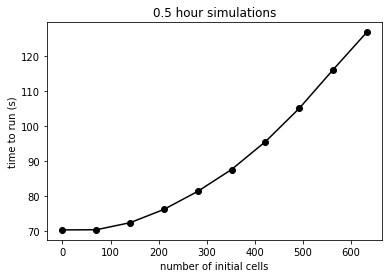

In [68]:
titl = '%s hour simulations'%t_final

plt.plot(n_cells,time_taken,'k-o')
plt.xlabel('number of initial cells')
plt.ylabel('time to run (s)')
plt.title(titl)
plt.show()